# Digit Recognizer with CNN
https://www.kaggle.com/c/digit-recognizer

###### Goal
The goal in this competition is to take an image of a handwritten single digit, and determine what that digit is.
For every ImageId in the test set, you should predict the correct label.

###### Metric
This competition is evaluated on the categorization accuracy of your predictions (the percentage of images you get correct).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline

### 1. read and visualize the data

In [4]:
data_path = './input'
filenames = os.listdir(data_path)
filenames.sort()

In [5]:
test_path = os.path.join(data_path,filenames[0])
train_path = os.path.join(data_path,filenames[1])

In [6]:

train_raw = pd.read_csv(train_path)
test_raw = pd.read_csv(test_path)
print('the shape of train_raw data is: ',train_raw.shape)
train_raw.head()

the shape of train_raw data is:  (42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# detect missing data
pd.isnull(train_raw).any().describe()

count       785
unique        1
top       False
freq        785
dtype: object

There is no missing data. So we are safe to proceed.

In [8]:
# extract the training data and label
trainY = train_raw['label']
trainX = train_raw.drop('label',axis=1)

testX = test_raw
del train_raw # to save some space by deleting old data

In [9]:
trainX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 251.2 MB


In [10]:
pd.isnull(trainY).describe()

count     42000
unique        1
top       False
freq      42000
Name: label, dtype: object

In [11]:
type(trainY.value_counts())
trainY.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

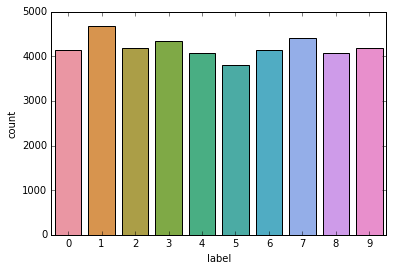

In [12]:
sns.countplot(trainY);

In [13]:
# to test our model for later, we will first choose a small fraction of the data
train_X = trainX.iloc[:2000,:]
train_Y = trainY.iloc[:2000,]


print('the type of train_X is {}, the type of train_Y is {}'.format(type(train_X),type(train_Y)))
print('the shape of train_X is {}, the shape of train_Y is {}'.format(train_X.shape,train_Y.shape))

the type of train_X is <class 'pandas.core.frame.DataFrame'>, the type of train_Y is <class 'pandas.core.series.Series'>
the shape of train_X is (2000, 784), the shape of train_Y is (2000,)


In [14]:
train_X.tail()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
1995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1999,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


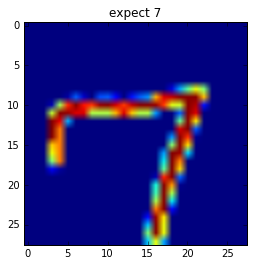

In [15]:
# randomly visualize an image
imgId = 1987
plt.figure(figsize=(8,4))
plt.imshow(train_X.loc[imgId].values.reshape((28,28)))
plt.title('expect {}'.format(train_Y.loc[imgId]))
plt.show()


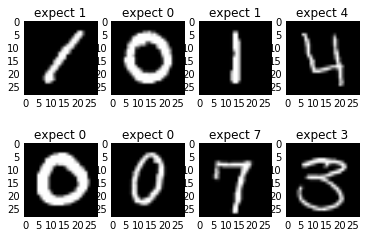

In [16]:
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(train_X.loc[i].values.reshape((28,28)), cmap=plt.get_cmap('gray'))
    plt.title('expect {}'.format(train_Y.loc[i]))
plt.show()

### 2. Data Preprocessing

To feed the data into CNN, we need to 
* rescale the pixel values [0,255] into the [0,1] interval, because neural networks prefer to deal with small input values
*  reshape the training data into the shape of (height,width,depth/channel). For the label data, we can use one-hot encoding (categorical encoding) to convert into 10-dim vectors. 
*  split the available data into training set and validation set to evaluate our model before submission
* 

In [17]:
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [18]:
import cv2

In [19]:
#choose the small data set to play around
# train_X = trainX.iloc[:2000,:]
# train_Y = trainY.iloc[:2000,]

#choose the whole dataset
train_X = trainX
train_Y = trainY

test_X = testX

print('the type of train_X is {}, the type of train_Y is {}'.format(type(train_X),type(train_Y)))
print('the shape of train_X is {}, the shape of train_Y is {}'.format(train_X.shape,train_Y.shape))

the type of train_X is <class 'pandas.core.frame.DataFrame'>, the type of train_Y is <class 'pandas.core.series.Series'>
the shape of train_X is (42000, 784), the shape of train_Y is (42000,)


In [20]:
# normalization, reshape and one-hot encoding

train_X = train_X.astype('float32')/255
test_X = test_X.astype('float32')/255

train_X = train_X.values.reshape((-1,28,28,1))
test_X = test_X.values.reshape((-1,28,28,1))

train_Y = to_categorical(train_Y) 


#train_X, train_Y become numpy array, rather than pandas data frame
print('train_X becomes {}, train_Y becomes {}'.format(type(train_X),type(train_Y)))
print('the shape of train_X is {}, the shape of train_Y is {}'.format(train_X.shape,train_Y.shape))

train_X becomes <class 'numpy.ndarray'>, train_Y becomes <class 'numpy.ndarray'>
the shape of train_X is (42000, 28, 28, 1), the shape of train_Y is (42000, 10)


In [69]:
# Split the train and the validation set for the fitting

#random_seed = 42 
# to keep the same randomnization

X_train, X_val, Y_train, Y_val = train_test_split(train_X, train_Y, test_size = 0.1, random_state=None, shuffle=True) 
# shuffle = True is the default value

print('the shape of X_train is {}, the shape of Y_train is {}'.format(X_train.shape,Y_train.shape))

the shape of X_train is (37800, 28, 28, 1), the shape of Y_train is (37800, 10)


### 3. CNN model

Now the input data X_train is of shape (28,28,1). I will try two copies of the series Conv2D -> MaxPooling2D, then the output is feed into a fully connected layer with softmax activation function for this single label, multi-class problem.

In [22]:
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau

from keras import optimizers

In [23]:
model = Sequential()

model.add(Conv2D(filters = 32,kernel_size = (3,3),activation='relu', padding = 'Same',input_shape=(28,28,1)))
model.add(Conv2D(filters = 64,kernel_size = (3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 64,kernel_size = (3,3),activation='relu', padding = 'Same'))
model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.3))

model.add(BatchNormalization())
model.add(Conv2D(filters = 128,kernel_size = (3,3),activation='relu', padding = 'Same'))
#model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.4))
#model.add(BatchNormalization())

#model.add(Conv2D(filters = 128,kernel_size = (3,3),activation='relu', padding = 'Same'))
#model.add(Dropout(0.4))

model.add(Flatten())
#model.add(Dense(128,activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10,activation='softmax'))
          
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 13, 64)        256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 6, 6, 64)          256       
__________

In [24]:
#optimizer = optimizers.RMSprop(lr=0.002,rho=0.9, epsilon=1.0e-8, decay=0.004)
optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0., amsgrad=False)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

I tried both RMSprop and Adam optimizers and found that Adam works better!

In [25]:
batch_size = 256
epochs = 10
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=1, min_lr=0.00005)

history = model.fit(X_train,Y_train, epochs=epochs, batch_size=batch_size,validation_data=(X_val,Y_val),callbacks = [reduce_lr])

Train on 37800 samples, validate on 4200 samples
Epoch 1/10
37800/37800 [==============================] - 152s 4ms/step - loss: 0.1785 - acc: 0.9453 - val_loss: 0.0467 - val_acc: 0.9852
Epoch 2/10
37800/37800 [==============================] - 152s 4ms/step - loss: 0.0449 - acc: 0.9861 - val_loss: 0.0380 - val_acc: 0.9867
Epoch 3/10
37800/37800 [==============================] - 152s 4ms/step - loss: 0.0303 - acc: 0.9904 - val_loss: 0.0365 - val_acc: 0.9876
Epoch 4/10
37800/37800 [==============================] - 153s 4ms/step - loss: 0.0250 - acc: 0.9921 - val_loss: 0.0352 - val_acc: 0.9902
Epoch 5/10
37800/37800 [==============================] - 153s 4ms/step - loss: 0.0213 - acc: 0.9932 - val_loss: 0.0263 - val_acc: 0.9926
Epoch 6/10
37800/37800 [==============================] - 153s 4ms/step - loss: 0.0172 - acc: 0.9943 - val_loss: 0.0329 - val_acc: 0.9900
Epoch 7/10
37800/37800 [==============================] - 152s 4ms/step - loss: 0.0149 - acc: 0.9947 - val_loss: 0.0246 - v

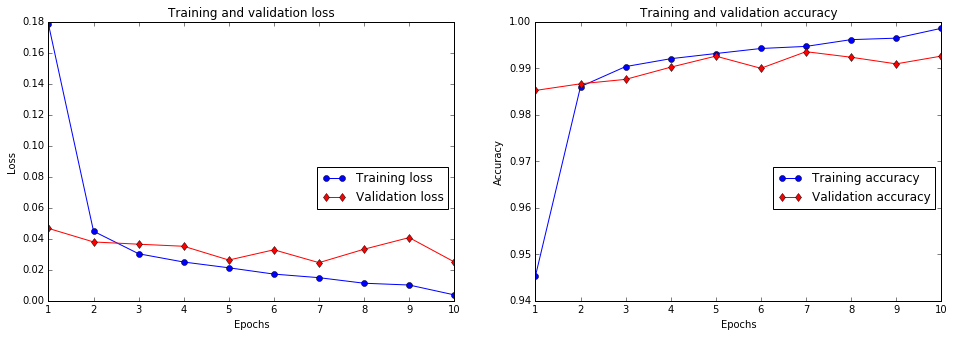

In [32]:
# check the progress with epochs
loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['acc']
val_acc = history.history['val_acc']


epochs_tick = range(1,len(loss)+1)
plt.figure(figsize=(16,5))

# plot the learning curves for the loss function 
plt.subplot(1, 2, 1)
plt.plot(epochs_tick,loss,'bo-',label='Training loss')
plt.plot(epochs_tick,val_loss,'rd-',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(bbox_to_anchor=(1, 0.5))

# plot the learning curves for accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_tick,acc,'bo-',label='Training accuracy')
plt.plot(epochs_tick,val_acc,'rd-',label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(bbox_to_anchor=(1, 0.5))
plt.show()

When the Dropout layers are commented out, the training accuracy can reach 99.8%, but there is obvious overfitting.
To increase the training accuracy and avoid overfitting at the same time, I will try data augmentation in the next section.

### 4. Data augmentation

In [33]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.,
    zoom_range=0.,
    horizontal_flip = False,
    vertical_flip = False,
    fill_mode ='nearest')


#datagen.fit(X_train)  #Only required if featurewise_center or featurewise_std_normalization or zca_whitening.

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau

Reduce learning rate when a metric has stopped improving.

Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
                              
model.fit(X_train, Y_train, callbacks=[reduce_lr])

In [34]:
batch_size = 256
epochs = 20

train_generator = train_datagen.flow(X_train,Y_train,batch_size=batch_size)
#validation_generator = val_datagen.flow(X_val,Y_val,batch_size=batch_size)
# we don't do image augmentation for test set

#annealer = LearningRateScheduler(lambda x: 2e-3 * 0.99 ** x)
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5,
                              patience=1, min_lr=0.00005)

history = model.fit_generator(
    train_generator,
    steps_per_epoch = X_train.shape[0] // batch_size,
    epochs=epochs,
#    samples_per_epoch = len(X_train),
    validation_data = (X_val,Y_val),
    callbacks=[reduce_lr])


Epoch 1/20
147/147 [==============================] - 152s 1s/step - loss: 0.2824 - acc: 0.9220 - val_loss: 0.1449 - val_acc: 0.9598
Epoch 2/20
147/147 [==============================] - 153s 1s/step - loss: 0.0947 - acc: 0.9716 - val_loss: 0.0427 - val_acc: 0.9852
Epoch 3/20
147/147 [==============================] - 154s 1s/step - loss: 0.0744 - acc: 0.9780 - val_loss: 0.0280 - val_acc: 0.9926
Epoch 4/20
147/147 [==============================] - 153s 1s/step - loss: 0.0634 - acc: 0.9805 - val_loss: 0.0292 - val_acc: 0.9905
Epoch 5/20
147/147 [==============================] - 153s 1s/step - loss: 0.0566 - acc: 0.9834 - val_loss: 0.0225 - val_acc: 0.9931
Epoch 6/20
147/147 [==============================] - 153s 1s/step - loss: 0.0505 - acc: 0.9856 - val_loss: 0.0231 - val_acc: 0.9919
Epoch 7/20
147/147 [==============================] - 153s 1s/step - loss: 0.0458 - acc: 0.9863 - val_loss: 0.0247 - val_acc: 0.9933
Epoch 8/20
147/147 [==============================] - 153s 1s/step - 

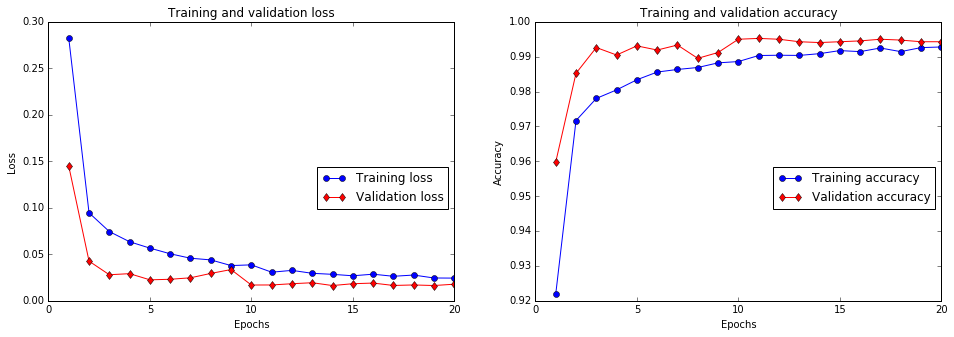

In [37]:
# check the progress with epochs
loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['acc']
val_acc = history.history['val_acc']


epochs_tick = range(1,len(loss)+1)
plt.figure(figsize=(16,5))

# plot the learning curves for the loss function 
plt.subplot(1, 2, 1)
plt.plot(epochs_tick,loss,'bo-',label='Training loss')
plt.plot(epochs_tick,val_loss,'rd-',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(bbox_to_anchor=(1, 0.5))

# plot the learning curves for accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_tick,acc,'bo-',label='Training accuracy')
plt.plot(epochs_tick,val_acc,'rd-',label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(bbox_to_anchor=(1, 0.5))
plt.show()

In [77]:
# save our model for later convenience
model.save('digitrecognizer_cnn_aug_v2.h5')

In [75]:
batch_size = 256
epochs = 1

train_generator = train_datagen.flow(X_train,Y_train,batch_size=batch_size)
#validation_generator = val_datagen.flow(X_val,Y_val,batch_size=batch_size)
# we don't do image augmentation for test set

#annealer = LearningRateScheduler(lambda x: 2e-3 * 0.99 ** x)
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5,
                              patience=1, min_lr=0.00005)

history = model.fit_generator(
    train_generator,
    steps_per_epoch = X_train.shape[0] // batch_size,
    epochs=epochs,
#    samples_per_epoch = len(X_train),
    validation_data = (X_val,Y_val),
    callbacks=[reduce_lr])


Epoch 1/1
147/147 [==============================] - 153s 1s/step - loss: 0.0251 - acc: 0.9921 - val_loss: 0.0071 - val_acc: 0.9976


In [76]:
batch_size = 256
epochs = 5

train_generator = train_datagen.flow(X_train,Y_train,batch_size=batch_size)
#validation_generator = val_datagen.flow(X_val,Y_val,batch_size=batch_size)
# we don't do image augmentation for test set

#annealer = LearningRateScheduler(lambda x: 2e-3 * 0.99 ** x)
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5,
                              patience=1, min_lr=0.00005)

history = model.fit_generator(
    train_generator,
    steps_per_epoch = X_train.shape[0] // batch_size,
    epochs=epochs,
#    samples_per_epoch = len(X_train),
    validation_data = (X_val,Y_val),
    callbacks=[reduce_lr])

Epoch 1/5
147/147 [==============================] - 155s 1s/step - loss: 0.0254 - acc: 0.9925 - val_loss: 0.0084 - val_acc: 0.9967
Epoch 2/5
147/147 [==============================] - 157s 1s/step - loss: 0.0280 - acc: 0.9917 - val_loss: 0.0076 - val_acc: 0.9969
Epoch 3/5
147/147 [==============================] - 161s 1s/step - loss: 0.0234 - acc: 0.9931 - val_loss: 0.0066 - val_acc: 0.9976
Epoch 4/5
147/147 [==============================] - 160s 1s/step - loss: 0.0254 - acc: 0.9927 - val_loss: 0.0064 - val_acc: 0.9976
Epoch 5/5
147/147 [==============================] - 160s 1s/step - loss: 0.0237 - acc: 0.9926 - val_loss: 0.0063 - val_acc: 0.9981


### 5. Result analysis

In [78]:
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn import metrics

pred = model.predict(X_val)
pred = np.argmax(pred,axis=1)
Yval = np.argmax(Y_val,axis=1)

In [80]:
metrics.accuracy_score(Yval, pred)

0.9980952380952381

In [81]:
metrics.confusion_matrix(Yval, pred)

array([[413,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 478,   1,   0,   0,   0,   0,   1,   0,   0],
       [  0,   0, 389,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 451,   0,   0,   0,   0,   0,   0],
       [  0,   1,   0,   0, 372,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 380,   1,   0,   0,   0],
       [  0,   0,   0,   0,   0,   1, 427,   0,   0,   0],
       [  0,   0,   1,   0,   0,   0,   0, 413,   0,   0],
       [  0,   0,   0,   0,   0,   1,   0,   0, 437,   0],
       [  0,   0,   0,   1,   0,   0,   0,   0,   0, 432]])

### 6. Submission

In [82]:
pred = model.predict(test_X)

In [83]:
# convert the one-hot vector back into a number
pred = np.argmax(pred,axis=1)

In [84]:
df = pd.DataFrame({"ImageId": range(1,pred.shape[0]+1),"Label": pred})
df.to_csv('submission_cnn_adam_v2.csv',header=True,index=False)

After submitting to Kaggle, the accuracy reaches 99.542%